# Pneumonia Detection using Convolutional Neural Networks

In [2]:
# Set the number of threads TensorFlow can use
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(8)  # Number of threads within an operation
tf.config.threading.set_inter_op_parallelism_threads(8)  # Number of threads between operations

* I started by defining the dataset's base directory and organizing it into train, val, and test subdirectories for smooth loading of data. This ensures a clear separation between training, validation, and test data.

* To understand the dataset better, I implemented a function to count the number of images in each category (NORMAL vs. PNEUMONIA). This helps verify if the dataset is balanced or if we need techniques to handle class imbalance:

In [3]:
import os
# Define base directory
base_dir = r'C:\Users\mouad\chest_xray'
# Define subdirectories for train,validation,test
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'val')
test_dir= os.path.join(base_dir,'test')
# Count the number of images in each category
def count_images(directory):
    normal_count= len(os.listdir(os.path.join(directory,'NORMAL')))
    pneumonia_count= len(os.listdir(os.path.join(directory,'PNEUMONIA')))
    print(f"Normal:{normal_count}, Pneumonia:{pneumonia_count}\n")
# Inspect datasets
print("Training set:")
count_images(train_dir)
print("Validation set:")
count_images(validation_dir)
print("Test set:")
count_images(test_dir)

Training set:
Normal:1341, Pneumonia:3875

Validation set:
Normal:92, Pneumonia:92

Test set:
Normal:150, Pneumonia:306



In the training set, there is a significant imbalance:
**1341 NORMAL vs. 3875 PNEUMONIA**
This means about 3 times more pneumonia cases than normal cases.

## Data Preprocessing 

**Image Preprocessing:**
- I set up image generators to preprocess and augment the images for the training and validation sets.
- For the training set, I applied multiple augmentations like random rotation, shift, shear, and zoom to introduce variability and prevent overfitting.
- I also normalized the pixel values to a range of [0, 1] to help the model learn efficiently.

**Validation Preprocessing:**

For the validation (and test) sets, I only rescaled the pixel values without applying augmentation to ensure we evaluate the model on real, unseen data.

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up image generators for loading and augmenting the images
train_datagen= ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range = 0.05,
    horizontal_flip = False,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1./255)

* I used the flow_from_directory method to load the images from the directories (train, val, and test) into the model. This method automatically labels images based on the folder names (i.e., NORMAL and PNEUMONIA).
* For the training set, images are resized to 224 x 224 and processed in batches of 32. I also enabled shuffling to ensure randomness in the data feeding, which helps prevent overfitting.
* For the validation and test sets, images are similarly resized and batched but without shuffling since we need the order to stay consistent for evaluation.
* Since this is a binary classification task (Normal vs. Pneumonia), I used class_mode='binary', which ensures that each image is labeled either as 'Normal' (0) or 'Pneumonia' (1)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = True
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

Found 5216 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 456 images belonging to 2 classes.


### Check the loading of data

To ensure everything works properly, we can visualize some images from the train_generator:

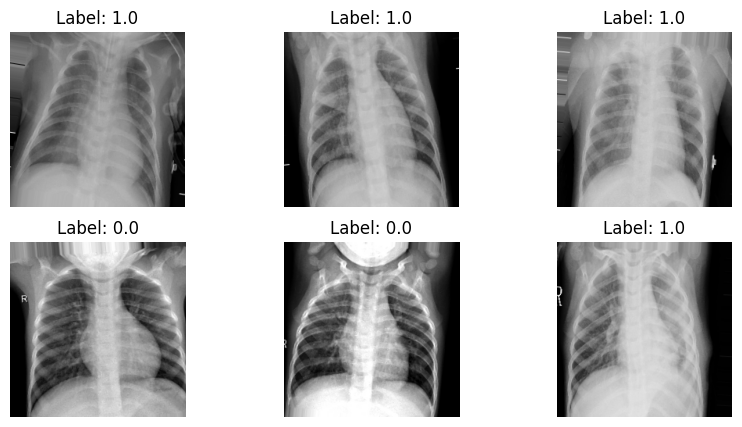

In [6]:
import matplotlib.pyplot as plt
# Get a batch of images and labels
images, labels = next(train_generator)

# Display the first 6 images
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])  # Display the image
    plt.title(f"Label: {labels[i]}")  # Show label
    plt.axis('off')  # Hide axis
plt.show()

In [7]:
from collections import Counter
import numpy as np

train_labels = np.concatenate([train_generator[i][1] for i in range(len(train_generator))])
val_labels = np.concatenate([validation_generator[i][1] for i in range(len(validation_generator))])
test_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

print(f"Training Class Distribution: {Counter(train_labels)}")
print(f"Validation Class Distribution: {Counter(val_labels)}")
print(f"Test Class Distribution: {Counter(test_labels)}")


Training Class Distribution: Counter({np.float32(1.0): 3875, np.float32(0.0): 1341})
Validation Class Distribution: Counter({np.float32(0.0): 92, np.float32(1.0): 92})
Test Class Distribution: Counter({np.float32(1.0): 306, np.float32(0.0): 150})


## Addressing Data Imbalance

### We noticed that the training dataset is imbalanced (more Pneumonia images than Normal), which can lead to model bias. To address this, I took steps to balance the dataset. We'll use class weights to handle the class imbalance. The class weights allow the model to "pay more attention" to the minority class (Normal class) by giving it higher weight in the loss function.

In [8]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

# Get class labels from the train_generator
class_labels = train_generator.classes

# Compute class weights based on the class distribution
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(class_labels), y=class_labels)

# Create a dictionary of class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Load a pretrained model ResNet50
height, width, channels = 224, 224, 3  # For images of size (224, 224)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, channels))

# Add custom layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Single neuron for binary classification

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train the model with class weights and generators
model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight_dict,  # Pass class weights here
)

C:\Users\mouad\SDS-CP021-pneumonia-detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 921s 5s/step - accuracy: 0.9453 - auc: 0.9757 - loss: 0.1628 - precision: 0.9779 - recall: 0.9494 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 62.1881 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 900s 6s/step - accuracy: 0.9798 - auc: 0.9966 - loss: 0.0601 - precision: 0.9961 - recall: 0.9766 - val_accuracy: 0.5000 - val_auc: 0.1961 - val_loss: 2.6789 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 798s 5s/step - accuracy: 0.9859 - auc: 0.9978 - loss: 0.0436 - precision: 0.9964 - recall: 0.9847 - val_accuracy: 0.5000 - val_auc: 0.1118 - val_loss: 1.8426 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 802s 5s/step - accuracy: 0.9900 - auc: 0.9996 - loss: 0.0261 - precision: 0.9976 - recall: 0.9890 - val_accuracy: 0.5000 - val_auc: 0.4674 - val_loss: 6.7178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10


*Load Pre-trained Model: The ResNet50 model, pre-trained on ImageNet, is loaded without the top layers (fully connected layers) to use it as a feature extractor. The input shape is defined based on the dataset dimensions

*Add Custom Layers: Custom layers are added on top of the ResNet50 base model:

*GlobalAveragePooling2D reduces dimensionality.

*A Dense layer with 1024 neurons and ReLU activation captures complex patterns.

*A final Dense layer with 1 neuron and sigmoid activation provides a binary classification output.

*Model Compilation: The model is compiled using the Adam optimizer with a learning rate of 0.0001. Binary cross-entropy loss is used for binary classification, and the model tracks performance metrics like accuracy, Precision, Recall, and AUC.

*Training:

In [9]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9083 - auc: 0.7173 - loss: 0.5853 - precision: 0.6185 - recall: 0.7353            
[0.3814185857772827, 0.9385964870452881, 0.934374988079071, 0.9771241545677185, 0.9554466009140015]
Test Loss: 0.3814185857772827
Test Accuracy: 0.9385964870452881
Test Precision: 0.934374988079071
Test Recall: 0.9771241545677185
Test AUC: 0.9554466009140015


We froze the layers of ResNet50 to prevent them from being updated during the first phase of training, allowing the model to focus on learning from the custom layers while retaining the pre-learned features from ImageNet.

After some initial training, we unfroze the last 50 layers of the base model to fine-tune them, allowing the model to better adapt to our specific task.

We recompiled the model with a smaller learning rate to prevent large weight changes, and we continued training the model.

We used key metrics like accuracy, precision, recall, and AUC to evaluate performance. 

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Train initial model
model.fit(train_generator, validation_data = validation_generator, epochs=5, batch_size=32, callbacks=[lr_scheduler])

# Unfreeze some deeper layers for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

# Train again with fine-tuning
model.fit(train_generator, validation_data = validation_generator, epochs=5, batch_size=32, callbacks=[lr_scheduler])

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9989 - auc: 1.0000 - loss: 0.0062 - precision: 0.9991 - recall: 0.9994 - val_accuracy: 0.9239 - val_auc: 0.9740 - val_loss: 0.3879 - val_precision: 0.8750 - val_recall: 0.9891 - learning_rate: 1.0000e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9980 - auc: 1.0000 - loss: 0.0050 - precision: 0.9984 - recall: 0.9989 - val_accuracy: 0.9185 - val_auc: 0.9695 - val_loss: 0.4009 - val_precision: 0.8667 - val_recall: 0.9891 - learning_rate: 1.0000e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.0035 - precision: 0.9998 - recall: 0.9994 - val_accuracy: 0.9185 - val_auc: 0.9693 - val_loss: 0.4230 - val_precision: 0.8667 - val_recall: 0.9891 - learning_rate: 1.0000e-04
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9990 - auc: 1.0000 - loss: 0.0037 - precision: 0.9995 - recall: 0.9991      
Epoch 4: ReduceLROnPlateau reducing learning rate

In [11]:
# Evaluate the model on the test set
test_results = model.evaluate(test_generator)
print(test_results)
# Extract the results
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_auc = test_results[4]

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9383 - auc_1: 0.7123 - loss: 0.8067 - precision_1: 0.6458 - recall_1: 0.7412            
[0.5437673926353455, 0.9561403393745422, 0.952531635761261, 0.983660101890564, 0.9471568465232849]
Test Loss: 0.5437673926353455
Test Accuracy: 0.9561403393745422
Test Precision: 0.952531635761261
Test Recall: 0.983660101890564
Test AUC: 0.9471568465232849


In [12]:
model.save("model.h5")  # Saves as an HDF5 file